# Assignment 2.1

Based on *Lecture 8.2 Image Segmentation*.

In [1]:
import pathlib

In [2]:
import imageio
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
import torch.nn as nn
import torchvision.transforms as transforms

Mount your Google Drive to access files within. File paths below assume:
1. You have created a shortcut to the shared folder,
2. Placed it at the top level, and
3. Renamed it to "DLMI".

In [4]:
import google
google.colab.drive.mount('/content/drive', force_remount=True)
drive = pathlib.Path('./drive/MyDrive') / 'DLMI'

Mounted at /content/drive


## Dataset preparation

*Hint:* You will need to modify the dataset class to solve the colorization task (Q1c).

In [5]:
class DatasetSTARE(torch.utils.data.Dataset):

    def __init__(self, database, subset, nimages, transform=None):
        """Constructor.

        database: path to the .npz file.
        subset: can be 'train', 'val', or 'test'.
        nimages: number of random cropped regions to extract from original images.
        transform: transforms used for data augmentation.
        """
        super().__init__()  # good practice to call the base constructor
        fimages = sorted((database / 'images').glob('*.ppm'))
        fmasks = sorted((database / 'masks1').glob('*.ppm'))
        if subset == 'train':
            indices = list(set(range(20)) - set((6, 7, 11, 12)))
        elif subset == 'val':
            indices = [6, 11]
        elif subset == 'test':
            indices = [7, 12]
        self._images = np.array([imageio.imread(x) for i, x in enumerate(fimages) if i in indices])
        self._masks = np.array([imageio.imread(x) for i, x in enumerate(fmasks) if i in indices])
        self._transform = transform
        self._nimages = nimages

    def __len__(self):
        """Dataset size."""
        return self._nimages

    def __getitem__(self, index):
        """Image and its corresponding mask at a given index."""
        image = self._images[index % len(self._images)]
        mask = self._masks[index % len(self._masks)]
        image = image.transpose([2,0,1])  # transpose dimensions such that image shape is: channels, height, width
        image = image.astype(np.float32) / 255  # convert image from 8-bit integer to 32-bit floating precision
        mask = mask.astype(np.float32) / 255
        image = torch.as_tensor(image.copy())  # cast NumPy array to Torch tensor
        mask = torch.as_tensor(mask.copy()).unsqueeze(0)
        if self._transform is not None:
            while True:
                combined = torch.cat([image, mask], dim=0)
                combined = self._transform(combined)
                image2 = combined[:len(image)]
                mask2 = combined[len(image):]
                if (100 * mask2.sum() / mask2.numel()) < 5:  # skip if mask occupies <5% of the image
                    continue
                image, mask = image2, mask2
                break
        return image, mask

*Hint:* `Compose` multiple data augmentation steps within a single transform (Q1a).

In [6]:
database = drive / 'datasets/STARE'

transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop([128,128]), 
    torchvision.transforms.RandomResizedCrop([64,64]), 
    torchvision.transforms.RandomRotation(80),
    torchvision.transforms.RandomVerticalFlip(p=0.5) 
])

loader_train = torch.utils.data.DataLoader(
    dataset=DatasetSTARE(database, 'train', nimages=500, transform=transform),  # you may edit number of training images
    batch_size=100,
    shuffle=True)

loader_val = torch.utils.data.DataLoader(
    dataset=DatasetSTARE(database, 'val', nimages=50, transform=transform),
    batch_size=100)

loader_test = torch.utils.data.DataLoader(
    dataset=DatasetSTARE(database, 'test', nimages=50, transform=transform))

<ipython-input-5-7655f8c05a4d>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  self._images = np.array([imageio.imread(x) for i, x in enumerate(fimages) if i in indices])
<ipython-input-5-7655f8c05a4d>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  self._masks = np.array([imageio.imread(x) for i, x in enumerate(fmasks) if i in indices])


In [7]:
def tcmap(fg):
    """Custom colormap with transparent background."""
    from matplotlib import colors
    fg = colors.to_rgb(fg)
    bg = colors.to_rgb((0,0,0))
    cmap = colors.LinearSegmentedColormap.from_list('binary', (bg,fg), 256)
    cmap._init()
    cmap._lut[:,-1] = np.linspace(0, 1, cmap.N + 3)
    return cmap

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


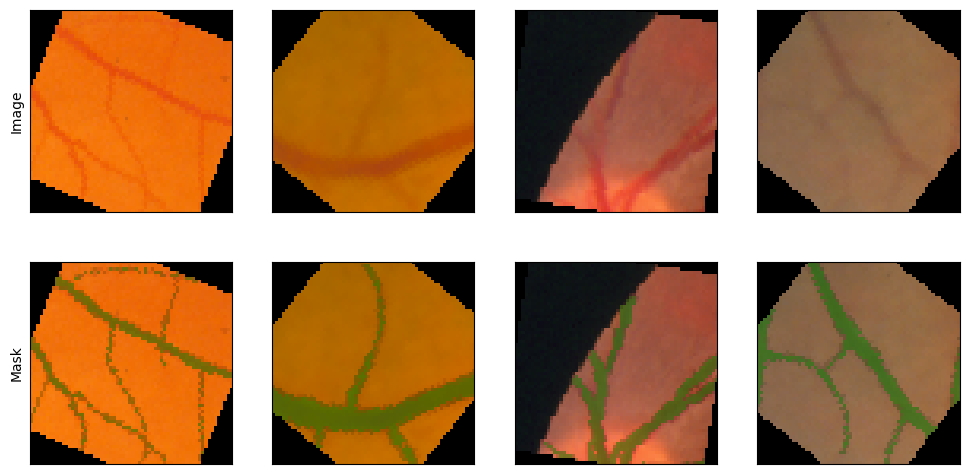

In [10]:
nimages = 4
fig, axs = plt.subplots(nrows=2, ncols=nimages, figsize=(nimages*3,2*3), subplot_kw={'xticks': [], 'yticks': []})
axs[0,0].set_ylabel('Image')
axs[1,0].set_ylabel('Mask')
i = 0
for images, masks in loader_train:
    if i >= nimages:
        break
    for image, mask in zip(images, masks):
        if i >= nimages:
            break
        axs[0,i].imshow(image.numpy().transpose([1,2,0]))
        axs[1,i].imshow(image.numpy().transpose([1,2,0]))
        axs[1,i].imshow(mask[0].numpy(), cmap=tcmap('green'), alpha=0.5)
        i += 1

## Network architecture

In [9]:
class UNet(torch.nn.Module):

    def __init__(self, nchannel=3, nclass=1):
        super().__init__()
        self.iput = self.conv(nchannel, 64)
        self.maxpool = torch.nn.MaxPool2d(2)
        self.enc1 = self.conv(64, 128)
        self.enc2 = self.conv(128, 256)
        self.enc3 = self.conv(256, 512)
        self.enc4 = self.conv(512, 1024 // 2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv(1024, 512 // 2)
        self.dec2 = self.conv(512, 256 // 2)
        self.dec3 = self.conv(256, 128 // 2)
        self.dec4 = self.conv(128, 64)
        self.oput = torch.nn.Conv2d(64, nclass, kernel_size=1)

    def forward(self, x):
        x1 = self.iput(x)  # input
        # encoder layers
        x2 = self.maxpool(x1)
        x2 = self.enc1(x2)
        x3 = self.maxpool(x2)
        x3 = self.enc2(x3)
        x4 = self.maxpool(x3)
        x4 = self.enc3(x4)
        x5 = self.maxpool(x4)
        x5 = self.enc4(x5)
        # decoder layers with skip connections and attention gates
        x = self.upsample(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        x = self.upsample(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec4(x)
        return self.oput(x)  # output

    def conv(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True))

## Model training

In [11]:
device = torch.device('cuda')
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters())  # you may use different optimizers or optimization parameters
cost = torch.nn.BCEWithLogitsLoss()  # you may use different cost functions

*Hint:* Override default weights after creating the model (Q1b).

In [12]:
def xavier_initialization(layer):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)

def kaiming_initialization(layer):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        nn.init.zeros_(layer.bias)

def zero_initialization(layer):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        nn.init.zeros_(layer.weight)
        nn.init.zeros_(layer.bias)

# Apply the chosen initialization method to the model
def initialize_weights(model, init_function):
    for m in model.modules():
        init_function(m)

#grayscale_transform = transforms.Grayscale(num_output_channels=3)

# Set up the device, model, optimizer, and loss
device = torch.device('cuda')
model = UNet().to(device)

# Apply the desired initialization method (e.g., xavier_initialization or kaiming_initialization)
initialize_weights(model, zero_initialization)

optimizer = torch.optim.Adam(model.parameters())  # you may use different optimizers or optimization parameters
cost = torch.nn.BCEWithLogitsLoss()

In [13]:
def dice(a, b):
    """Compute the Sørensen–Dice coefficient between two masks."""
    return 100 * np.sum(a[b > 0]) * 2 / (np.sum(a) + np.sum(b))

In [14]:
score_threshold = 0.5

In [15]:
num_epochs = 20
losses_train = []
losses_val = []
dices_val = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    loss_train = []
    for images, masks in loader_train:
        optimizer.zero_grad()
        predictions = model(images.to(device))
        losses = cost(predictions, masks.to(device))
        loss = losses.mean()
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())
    losses_train.append(sum(loss_train) / loader_train.batch_size)

    with torch.no_grad():
        loss_val = []
        dice_val = []
        for images, masks in loader_val:
            predictions = model(images.to(device))
            losses = cost(predictions, masks.to(device))
            loss = losses.mean()
            loss_val.append(loss.item())
            dice_val.extend([dice(x, y) for x, y in zip(predictions.squeeze(1).cpu().numpy() > score_threshold, masks.squeeze(1).numpy())])
        losses_val.append(sum(loss_val) / loader_val.batch_size)
        dices_val.append(dice_val)

  0%|          | 0/20 [00:00<?, ?it/s]

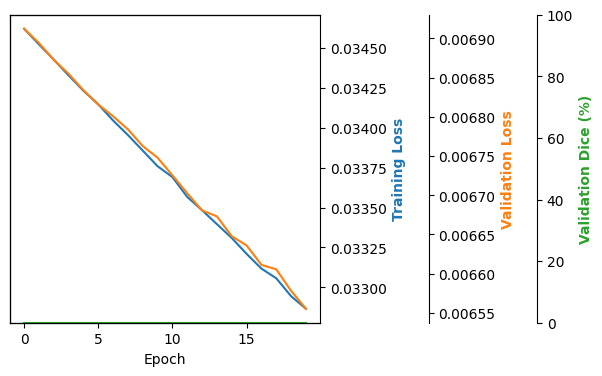

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(losses_train, 'C0')
ax.set_ylabel('Training Loss', c='C0', fontweight='bold')
ax2 = ax.twinx()
ax2.plot(losses_val, 'C1')
ax2.set_ylabel('Validation Loss', c='C1', fontweight='bold')
ax2.spines['right'].set_position(('axes', 1 + 0.35))
ax3 = ax.twinx()
ax3.spines['right'].set_position(('axes', 1 + 0.35 * 2))
ax3.plot(np.mean(dices_val, axis=1), 'C2')
ax3.set_ylim(0, 100)
ax3.set_ylabel('Validation Dice (%)', c='C2', fontweight='bold')
ax.set_xlabel('Epoch')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
pass

## Model evaluation

Evaluate model on a few images, display results.

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


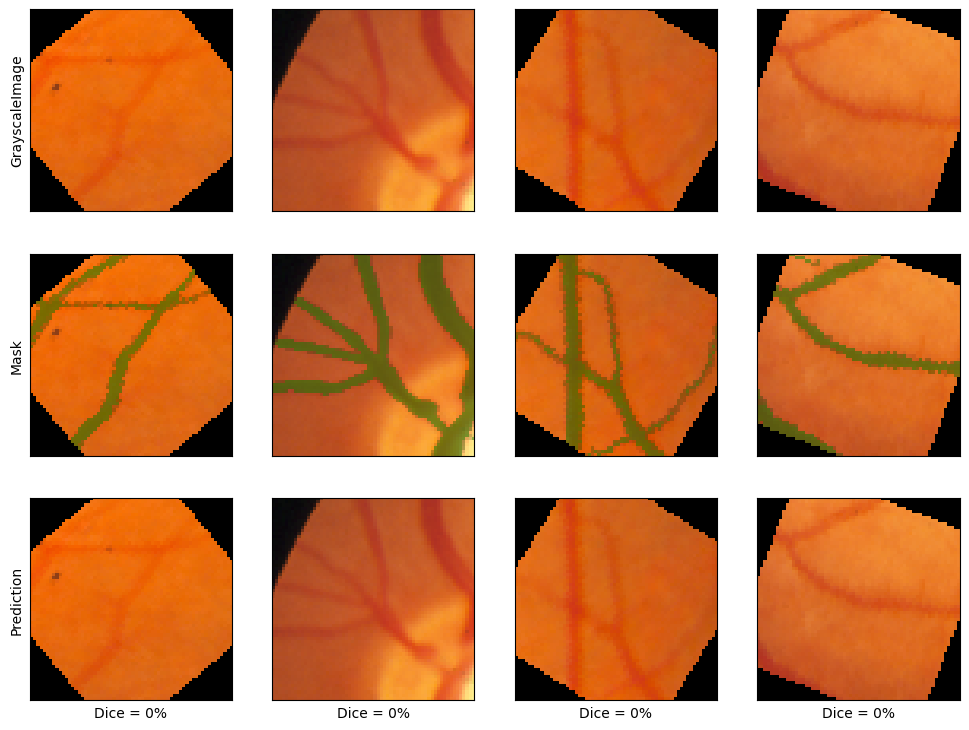

In [20]:
nimages = 4
fig, axs = plt.subplots(nrows=3, ncols=nimages, figsize=(nimages*3,3*3), subplot_kw={'xticks': [], 'yticks': []})
axs[0,0].set_ylabel('GrayscaleImage')
axs[1,0].set_ylabel('Mask')
axs[2,0].set_ylabel('Prediction')
i = 0
with torch.no_grad():
    model.eval()
    for images, masks in loader_test: 
        if i >= nimages:
            break
        predictions = model(images.to(device))
        for image, mask, prediction in zip(images, masks, predictions):
            if i >= nimages:
                break
            image = image.numpy()
            mask = mask[0].numpy()
            prediction = prediction[0].cpu().numpy() > score_threshold
            axs[0,i].imshow(image.transpose([1,2,0]))
            axs[0,i].imshow(image.transpose([1,2,0]))
            axs[1,i].imshow(image.transpose([1,2,0]))
            axs[1,i].imshow(mask, cmap=tcmap('green'), alpha=0.5)
            axs[2,i].imshow(image.transpose([1,2,0]))
            if prediction.any():
                axs[2,i].imshow(prediction, cmap=tcmap('green'), alpha=0.5)
            axs[2,i].set_xlabel(f'Dice = {dice(prediction, mask):.0f}%')
            i += 1

Evaluate model on all test images, compute and plot Dice for a given score threshold.

In [21]:
dices = []
with torch.no_grad():
    model.eval()
    for images, masks in loader_test: 
        predictions = model(images.to(device))
        for mask, prediction in zip(masks, predictions):
            mask = mask[0].numpy()
            prediction = prediction[0].cpu().numpy() > score_threshold
            dices.append(dice(prediction, mask))

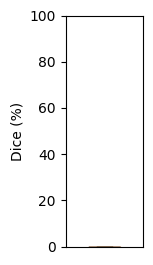

In [19]:
fig, ax = plt.subplots(figsize=(1,3))
ax.boxplot(dices, widths=0.4)
ax.set_xticks([])
ax.set_ylim(0, 100)
ax.set_ylabel('Dice (%)')
pass

---
<small>Uneri & Sisniega, 2023</small>